In [4]:
import des_queue
import simpy as sip
import numpy as np
from collections import deque
import pandas as pd
import os
import csv
from pathlib import Path
import matplotlib.pyplot as plt
import warnings
import DES
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore')

In [5]:
def find_lowest_sign(col1,col2,alpha):
    right = len(col1)-1
    while is_significant(right, col1, col2, alpha):
        right -= 1
        # print(ttest_ind(col1[:right], col2[:right])[1])
        # print(right)
    # print('last',right)
    return right +1

def is_significant(idx, col1, col2, alpha):
    if ttest_ind(col1[:idx], col2[:idx])[1] < alpha:
        return True
    else:
        return False

def write_signif(n_means, comparison, rho, low_idx_sign, alpha, name):
    """Log the current data to the file with the experiment.
     If the file does not exist, make file and add header row.
     :return void
     """

    if not os.path.exists('signif_data'):
        os.makedirs("signif_data")

    # if file does not exist yet make one and write the column headers in it
    my_file = Path(os.path.join("signif_data", name + ".csv"))

    if not my_file.is_file():
        with open(os.path.join("signif_data", name + ".csv"), "w+") as f:
            wr = csv.writer(f)
            wr.writerow(["n_means","comparison", "rho", "low_idx_sign", "alpha"])

    # log the data
    with open(os.path.join("signif_data", name + ".csv"), "a") as f:

        wr = csv.writer(f)
        wr.writerow([n_means, comparison, rho, low_idx_sign, alpha])
    return None


In [39]:
mulamb = [(1,0.99),(1,0.98), (1,0.94),(1,0.91), (1,0.83)]

In [69]:
rhowait = {1:[], 2:[], 4:[]}
rhos = [l for m,l in mulamb]
nr_means = 49
alpha = 0.05
for mu,lamd in mulamb:
    rho = lamd
    # print(rho)

    all_means = np.empty((nr_means,5))
    for _,n in enumerate([1,2,4]):
        name = f"servers_{rho}_50"
        res, cutoffs = DES.waiting_times(name)
        # print('start',rhowait[lamd][n])
        results = res[n]
        ct = cutoffs[n]

        cur_means = [np.mean(results[ct[i]+int((ct[i+1]-ct[i])/2):ct[i+1]]) for i in range(len(ct)-1)]
        # means_n.append(np.mean(results[ct[-2]:ct[-1]]))
        all_means[:,n] = cur_means
    for i,(a,b) in enumerate(zip([1,1,2],[2,4,4])):
        # tes_res = ttest_ind(all_means[:,a],all_means[:,b])[1]
        low_idx =find_lowest_sign(all_means[:,a],all_means[:,b],alpha)
        write_signif(nr_means, (a,b),rho,low_idx, alpha, f'drive_2_sign_data{nr_means}')

# means for nr_sim simulations, [1,2,4]
# print(all_means)

In [70]:
res = pd.read_csv(f'signif_data/drive_2_sign_data{nr_means}.csv')
res

,n_means,comparison,rho,low_idx_sign,alpha
0,49,"(1, 2)",0.99,26,0.05
1,49,"(1, 4)",0.99,2,0.05
2,49,"(2, 4)",0.99,49,0.05
3,49,"(1, 2)",0.98,26,0.05
4,49,"(1, 4)",0.98,6,0.05
5,49,"(2, 4)",0.98,8,0.05
6,49,"(1, 2)",0.94,5,0.05
7,49,"(1, 4)",0.94,5,0.05
8,49,"(2, 4)",0.94,7,0.05
9,49,"(1, 2)",0.91,4,0.05


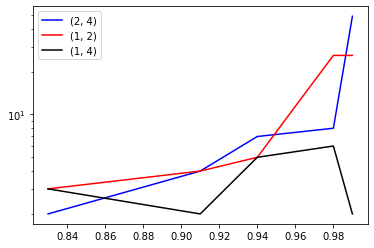

In [71]:

# for i in set(res['comparison']):

all_comp = list(set(res['comparison']))
cur_comp = res[res['comparison']==all_comp[0]]
plt.semilogy(cur_comp['rho'],cur_comp['low_idx_sign'], label = f'{all_comp[0]}',color='blue')
cur_comp = res[res['comparison']==all_comp[1]]
plt.semilogy(cur_comp['rho'],cur_comp['low_idx_sign'], label = f'{all_comp[1]}',color='red')
cur_comp = res[res['comparison']==all_comp[2]]
plt.semilogy(cur_comp['rho'],cur_comp['low_idx_sign'], label = f'{all_comp[2]}',color='black')
# plt.ylim((0,0.01))
plt.legend()

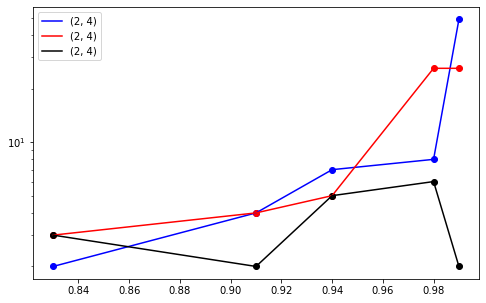

In [72]:
colors = ['blue','red','black']
plt.figure(figsize=(8,5))
for i, comp in enumerate(list(set(res['comparison']))):
    cur_comp = res[res['comparison']==comp]
    plt.semilogy(cur_comp['rho'],cur_comp['low_idx_sign'],
                 label = f'{all_comp[0]}',color=colors[i])
    plt.scatter(cur_comp['rho'],cur_comp['low_idx_sign'],color=colors[i])

# cur_comp = res[res['comparison']==all_comp[1]]
# plt.semilogy(cur_comp['rho'],cur_comp['low_idx_sign'], label = f'{all_comp[1]}',color='red')
# cur_comp = res[res['comparison']==all_comp[2]]
# plt.semilogy(cur_comp['rho'],cur_comp['low_idx_sign'], label = f'{all_comp[2]}',color='black')
# # plt.ylim((0,0.01))
plt.legend()